# Show caseon training data

In [22]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from scipy.interpolate import interp1d
sys.path.append('../')
from matplotlib.ticker import FormatStrFormatter
import emcee
from delight.io import *
from delight.utils import *
from delight.utils_cy import approx_flux_likelihood_cy
from delight.photoz_gp import PhotozGP
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel
from matplotlib.ticker import FormatStrFormatter

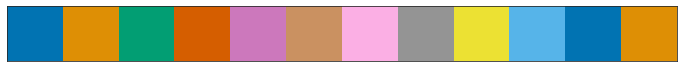

In [23]:
# Setting style
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
sns.set_style('white')
sns.set_palette("colorblind", 12) #Paired
sns.palplot(sns.color_palette())
rcParams['xtick.major.size'] = 2
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 2
rcParams['ytick.major.width'] = 1
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
colTF = sns.color_palette()[2] 
colGP = sns.color_palette()[0]
colGP2 = sns.color_palette()[5]

In [24]:
configfilename="tmpsim/parametersTest.cfg"

In [25]:
# Read parameter files and data (file names need to be updated)
# Load SEDS, bands, grids, etc.
params = parseParamFile(configfilename, verbose=False)
#params['training_catFile'] = '/Users/bl/Dropbox/repos/Delight/data/galaxies-fluxredshifts_small.txt'
#params['target_catFile'] = '/Users/bl/Dropbox/repos/Delight/data/galaxies-fluxredshifts_small2.txt'
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
f_mod = readSEDs(params)
numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
print('Number of Training Objects', numObjectsTraining)

Number of Training Objects 1000


<ipython-input-25-9f5e795f15c5>:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))


In [26]:
# read filter coefficients (Gaussian mixture model approximation)
# Then compute mean and size of filters, for plotting later.
bandwavelengths = np.zeros((numBands, 2))
for i in range(numBands):
    amps, mus, sigs = bandCoefAmplitudes[i, :], bandCoefPositions[i, :], bandCoefWidths[i, :]
    lamMin, lamMax = np.min(mus - 2*sigs), np.max(mus + 2*sigs) 
    x = np.linspace(lamMin, lamMax, 5000)
    y = np.sum(np.exp(-0.5*((mus[None, :]-x[:, None])/sigs[None, :])**2), axis=1)
    bandwavelengths[i, 0] = np.average(x, weights=y)
    bandwavelengths[i, 1] = np.sqrt(np.average((x-bandwavelengths[i, 0])**2, weights=y))

In [27]:
#plt.errorbar(bandwavelengths[:, 0], fluxes, yerr=fluxesVar**0.5, xerr=bandwavelengths[:, 1], fmt='+')

In [28]:
# Load templates
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
fmt = '.dat'
sed_interps = np.zeros((len(sed_names), ), dtype=object)
for i, sed_name in enumerate(sed_names):
    seddata = np.genfromtxt(dir_seds + '/' + sed_name + fmt)
    seddata[:, 1] *= seddata[:, 0]**2. / 3e18
    ref = np.interp(lambdaRef, seddata[:, 0], seddata[:, 1])
    seddata[:, 1] /= ref
    sed_interps[i] = interp1d(seddata[:, 0], seddata[:, 1])

In [29]:
# Create GP 
# Could change hyperparameters here
DL = approx_DL()
gp = PhotozGP(f_mod, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
              params['lines_pos'], params['lines_width'],
              params['V_C'], params['V_L'],
              params['alpha_C'], params['alpha_L'],
              redshiftGridGP, use_interpolators=True)

In [30]:
# We need a function to construct the GP residuals in wavelength space, with the two RBF kernels
# (In delight this is done in redshift/band space, but we want the actual SED here)

lamMin = 3.7e3#np.min(bandwavelengths[:, 0]-2*bandwavelengths[:, 1])
lamMax = 1.1e4#np.max(bandwavelengths[:, 0]+2*bandwavelengths[:, 1])
#wavs = np.logspace(np.log10(lamMin), np.log10(lamMax), 80) 
wavs=np.linspace(lamMin, lamMax, 10)
#wavs_hi = np.logspace(np.log10(lamMin), np.log10(lamMax), 2000) 
#wavs_hi=np.linspace(lamMin, lamMax, 1000)
wavs_hi=np.linspace(lamMin, lamMax, 20)



def drawSEDresiduals(gp, z, ell, wavs):
    opz = 1 + z
    dWav = wavs[:, None] - wavs[None, :]
    
    cov_C = gp.kernel.var_C *\
        np.exp(-0.5*(dWav/opz/gp.kernel.alpha_C)**2)
    
    cov_L = 0*cov_C
    
    for mu, sig in zip(gp.kernel.lines_mu, gp.kernel.lines_sig):
        cov_L += gp.kernel.var_L *\
            np.exp(-0.5*(dWav/opz/gp.kernel.alpha_L)**2) *\
            np.exp(-0.5*((wavs[:, None]/opz-mu)/sig)**2) *\
            np.exp(-0.5*((wavs[None, :]/opz-mu)/sig)**2)
        
    fac = opz * ell / 4 / np.pi / gp.kernel.DL_z(z)**2
    
    residuals = fac * np.random.multivariate_normal(0*wavs, cov_C + cov_L)
    
    numB = gp.kernel.fcoefs_amp.shape[0]
    
    filters = np.zeros((numB, wavs.size))
    
    for i in range(numB):
        for amp, mu, sig in zip(gp.kernel.fcoefs_amp[i, :],
                                gp.kernel.fcoefs_mu[i, :],
                                gp.kernel.fcoefs_sig[i, :]):
            filters[i, :] += amp * np.exp(-0.5*((wavs-mu)/sig)**2)
            
    return residuals, fac, cov_C + cov_L, filters

## Read training data

In [36]:
numZ = redshiftGrid.size
all_z = np.zeros((numObjectsTraining, ))
all_fluxes = np.zeros((numObjectsTraining, numBands))
all_fluxes_var = np.zeros((numObjectsTraining, numBands))
all_bestTypes = np.zeros((numObjectsTraining, ), dtype=int)
all_model_mean = np.zeros((numZ, numObjectsTraining, numBands))
all_model_covar = np.zeros((numZ, numObjectsTraining, numBands))

loc = - 1
trainingDataIter1 = getDataFromFile(params, 0, numObjectsTraining,prefix="training_", getXY=True,CV=True)

# loop on training data

for z, normedRefFlux,\
    bands, fluxes, fluxesVar,\
    bandsCV, fluxesCV, fluxesVarCV,\
        X, Y, Yvar in trainingDataIter1:
    loc += 1

    themod = np.zeros((1, f_mod.shape[0], bands.size))
    
    # loop on templates
    for it in range(f_mod.shape[0]):
        for ib, band in enumerate(bands):
            themod[0, it, ib] = f_mod[it, band](z)
            
    # compute  the likelihood        
    chi2_grid, ellMLs = scalefree_flux_likelihood(fluxes, fluxesVar, themod, returnChi2=True)
    
    
    print("1) model = ", themod)
    print("1) fluxes = ",fluxes)
    
    
    print("z = ",z)
    
    print("ellMLs.shape = ",ellMLs.shape, "ellMLs = ",ellMLs)
    
    bestType = np.argmin(chi2_grid)
    
    print("bestType = ",bestType)
    
    ell = ellMLs[0, bestType]
    #ell2 = normedRefFlux * 4 * np.pi * (DL(z)**2. * (1+z)) / params['fluxLuminosityNorm']
    
    # fit the gaussian process
    X[:, 2] = ell
    
    print("X.shape = ",X.shape, " X =", X)
    
    gp.setData(X, Y, Yvar, bestType)
    model_mean, model_covar = gp.predictAndInterpolate(redshiftGrid, ell=ell)
    all_model_mean[:, loc, :], all_model_covar[:, loc, :] = model_mean, model_covar

    print("2) model_mean = ",model_mean)
    print("2) fluxes = ",fluxes)
    
    
    all_z[loc] = z
    all_bestTypes[loc] = bestType
    all_fluxes[loc, bands] = fluxes
    all_fluxes_var[loc, bands] = fluxesVar
    
    
    
    
    
    if loc < 10:
        if True:
            fac = ell * (1+z)**2. / DL(z)**2. / (4*np.pi) * 1e4/2.3
            sedtf = sed_interps[bestType](wavs/(1+z)) * fac
            sedtf_hi = sed_interps[bestType](wavs_hi/(1+z)) * fac

            if True:
                residuals, fac, cov, filters = drawSEDresiduals(gp, z, ell, wavs)
                residuals_hi, fac_hi, cov_hi, filters_hi = drawSEDresiduals(gp, z, ell, wavs_hi)
                filternorms = [np.trapz(filters_hi[ib], x=wavs_hi) for i, ib in enumerate(bands)]
                sed = np.random.uniform(wavs.size) * wavs
                #icov = np.linalg.inv(cov)
                det = np.linalg.det(cov)
                
                def lnprob(sed, sedtf, fac, fluxes, bands, wavs, wavs_hi, cov, det, filters_hi, filternorms):
                    sedfluxes = np.zeros((bands.size, ))
                    sed_hi = interp1d(wavs, sed, kind='cubic')(wavs_hi)#np.interp(wavs_hi, wavs, sed)
                    for i, ib in enumerate(bands):
                        sedfluxes[i] = np.trapz(filters_hi[ib]*sed_hi, x=wavs_hi) / filternorms[i]
                    lp = np.sum(-0.5*(sedfluxes - fluxes)**2/fluxesVar) #- 0.5 * np.prod(np.log(fluxesVar))
                    res = (sed - sedtf) / fac
                    #print(lp,  np.sum(-0.5*np.dot(res, np.linalg.solve(cov, res))), end=" ")
                    #lp += np.sum(-0.5*np.dot(res, np.linalg.solve(cov, res))) 
                    return lp
                ndim = wavs.size
                #nwalkers = ndim * 10
                nwalkers =  10
                
                #ndim, nwalkers = 5, 100
                #ivar = 1. / np.random.rand(ndim)
                #p0 = np.random.randn(nwalkers, ndim)
                #sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[ivar])
                #sampler.run_mcmc(p0, 10000)
                
                ymax = fluxes.max() * 1.2
                ymin = fluxes.min() / 2
                p0 = np.random.uniform(low=ymin, high=ymax, size=ndim * nwalkers).reshape((nwalkers, ndim))
                for i in range(nwalkers):
                    p0[i] = 1*sedtf + fac * np.random.multivariate_normal(0*wavs, cov)
                    print("nwalker=",i," p0[i]=",p0[i]," ::: ",lnprob(p0[i], sedtf, fac, fluxes, bands, wavs, wavs_hi, cov, det, filters_hi, filternorms))
                #stop
                sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                                args=[sedtf, fac, fluxes, bands, wavs, wavs_hi, cov, det, filters_hi, filternorms])
                pos, prob, state = sampler.run_mcmc(p0, 20,progress=True)
                sampler.reset()
                sampler.run_mcmc(pos, 20,progress=True)
                print("Mean acceptance fraction: {0:.3f}"
                        .format(np.mean(sampler.acceptance_fraction)))
                seds = sampler.flatchain
                sedmean, sedstd = seds.mean(axis=0), seds.std(axis=0)
                sedmean_hi = interp1d(wavs, sedmean, kind='cubic')(wavs_hi)
                sedstd_hi = interp1d(wavs, sedstd, kind='cubic')(wavs_hi)

            fig, ax = plt.subplots(1, 1, figsize=(6, 3))
            #ax.plot(wavs, sedtf, 'k')
            ax.plot(wavs_hi, sedtf_hi, c=colTF, label='Standard template fitting') 
            ax.plot(wavs_hi, sedmean_hi, color=colGP, label='New method')
            ax.fill_between(wavs_hi, sedmean_hi+sedstd_hi, sedmean_hi-sedstd_hi, color=colGP, alpha=0.4)
            
            
            #ax.fill_between(wavs, sedmean+sedstd, sedmean-sedstd, color='b', alpha=0.2)
            #for w in wavs:
            #    ax.axvline(w, c='gray', alpha=0.5, lw=0.5)
            #for i in range(seds.shape[0]):
            #    ax.plot(wavs_hi, interp1d(wavs, seds[i, :], kind='cubic')(wavs_hi), c='gray', alpha=0.2, lw=0.3)
            ax.errorbar(bandwavelengths[bands, 0], fluxes, 
                        xerr=bandwavelengths[bands, 1], yerr=np.sqrt(fluxesVar),
                       fmt='o', c='k', markersize=5, label='Deep training photometry')
            ax.errorbar(bandwavelengths[bandsCV, 0], fluxesCV, 
                        xerr=bandwavelengths[bandsCV, 1], yerr=np.sqrt(fluxesVarCV),
                       fmt='s', c='b', markersize=5, label='Shallow testing photometry')
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.set_ylabel(r'$L_\nu(\lambda)$')
            #ax.set_yticks(np.linspace(10**-5, 10**-4, 10))
            ax.set_xlabel(r'$\lambda$ [$\AA$]')
            ax.set_xlim([lamMin, lamMax])
            ax.set_xticks(np.linspace(4e3, 1e4, 7))
            ax.set_xticklabels(np.linspace(4e3, 1e4, 7))
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            #ax.set_ylim([0.5*np.min(sedtf), 2.5*np.max(sedtf)])
            ax.legend(ncol=2, frameon=False, loc='upper left')
            fig.tight_layout()
            fig.savefig('./figures/showcase/traininggalaxy_fnulambda-'+str(loc)+'.pdf')
            
        if False:
            fig, axs = plt.subplots(4, numBands//4, figsize=(12, 6), sharex=True, sharey=True)
            for i in range(numBands//4):
                axs[-1, i].set_xlabel('Redshift')
            for i in range(4):
                axs[i, 0].set_ylabel('Flux')
            axs = axs.ravel()
            temp = np.concatenate([ell*f_mod[bestType, i](redshiftGrid)*redshiftGrid**2
                                   for i, bnm in enumerate(bandNames)])
            axs[-1].set_ylim([0.5*np.min(temp), 2*np.max(temp)])
            for i, bnm in enumerate(bandNames):
                axs[i].text(0.1, 0.8*np.max(temp), bnm.replace('_', ' '))
                axs[i].plot(redshiftGrid, ell*f_mod[bestType, i](redshiftGrid)*redshiftGrid**2,
                            c=colTF, label='Standard template fitting', ls='dashed', zorder=2)
                axs[i].plot(redshiftGrid, model_mean[:, i]*redshiftGrid**2,
                            c=colGP, label='New method', zorder=1)#, label=bnm.replace('_', ' '))
                axs[i].fill_between(redshiftGrid, 
                                    (model_mean[:, i]-np.sqrt(model_covar[:, i]))*redshiftGrid**2, 
                                    (model_mean[:, i]+np.sqrt(model_covar[:, i]))*redshiftGrid**2,
                                    color=colGP, alpha=0.4, zorder=0)
                if i in bands:
                    pos = list(bands).index(i)
                    axs[i].errorbar(z, fluxes[pos]*z**2, yerr=np.sqrt(fluxesVar[pos])*z**2, c='k', markersize=5, fmt='o')
                if i in bandsCV:
                    pos = list(bandsCV).index(i)
                    axs[i].errorbar(z, fluxesCV[pos]*z**2, yerr=np.sqrt(fluxesVarCV[pos])*z**2, c='b', markersize=5, fmt='s')
                #axs[i].set_ylim([np.min(model_mean), np.max(model_mean)])
                axs[i].set_xticks([0, 0.5, 1.0])
            axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
            axs[-1].set_yscale('log')
            axs[-1].set_xlim([0, 1.5])
            fig.subplots_adjust(wspace=0, hspace=0)
            fig.savefig('./figures/showcase/traininggalaxy_fluxredshiftmodel-'+str(loc)+'.pdf')
            
    else:
        break

1) model =  [[[4.21999085e-08 5.65767585e-08 1.23301184e-07 2.97698526e-07
   1.05781239e-06 2.32892545e-06]
  [2.77435129e-07 6.24249071e-07 1.10463842e-06 1.47053721e-06
   1.91781846e-06 2.95743479e-06]
  [9.82758814e-07 1.76293320e-06 2.54470040e-06 2.88018271e-06
   3.57844603e-06 4.56703023e-06]
  [2.71600787e-06 3.33241471e-06 3.89554336e-06 4.56640314e-06
   5.17148307e-06 5.59646151e-06]
  [5.16682398e-06 6.28473220e-06 6.28857389e-06 6.95143891e-06
   7.00097130e-06 8.11733760e-06]
  [2.56611652e-06 3.64053645e-06 4.54402053e-06 4.79651195e-06
   5.11580304e-06 5.88009517e-06]
  [1.23849300e-05 1.24500223e-05 1.18387014e-05 1.10676011e-05
   1.05990957e-05 9.91453160e-06]
  [2.78842161e-05 2.52208876e-05 2.24543177e-05 1.93935983e-05
   1.71149438e-05 1.55283813e-05]]]
1) fluxes =  [2.72111406 3.52621314 3.79059658 4.72490472 4.98551306 5.54940699]
z =  1.9722299138465411
ellMLs.shape =  (1, 8) ellMLs =  [[3358859.91371741 2770959.10287451 1549035.75803175 1003906.17209946
  

ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance

In [ ]:
# Create the redshift / photometric model
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
f_mod_grid = np.zeros((redshiftGrid.size, len(sed_names),
                  len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod_grid[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name +
                                '_fluxredshiftmod.txt')

In [ ]:
# Only run that to look at redshift PDFs
p_t = params['p_t'][all_bestTypes][None, :]
p_z_t = params['p_z_t'][all_bestTypes][None, :]
prior = np.exp(-0.5*((redshiftGrid[:, None]-all_z[None, :])/params['zPriorSigma'])**2)
Ncompress = params['Ncompress']

fig, axs = plt.subplots(1, 2, figsize=(8, 2.5), sharey=True)

loc = -1
targetDataIter = getDataFromFile(params, 0, numObjectsTraining,
                                 prefix="target_", getXY=False)
for z, normedRefFlux, bands, fluxes, fluxesVar, bCV, fCV, fvCV in targetDataIter:
    loc += 1
    if loc < 100:
        fulllike_grid = np.zeros((all_model_mean.shape[0], all_model_mean.shape[1]))
        ell_hat_z = normedRefFlux * 4 * np.pi\
            * params['fluxLuminosityNorm'] \
            * (DL(redshiftGrid)**2. * (1+redshiftGrid))
        ell_hat_z[:] = 1.0
        params['ellPriorSigma'] = 0.2
        approx_flux_likelihood_cy(fulllike_grid,
            all_model_mean.shape[0], all_model_mean.shape[1], bands.size,
            fluxes, fluxesVar, all_model_mean[:, :, bands],
            all_model_covar[:, :, bands], 
            ell_hat_z, (ell_hat_z*params['ellPriorSigma'])**2
        )
        fulllike_grid *= prior
        evidences = np.trapz(fulllike_grid, x=redshiftGrid, axis=0)
        sortind = np.argsort(evidences)[::-1][0:Ncompress]
        like_grid = fulllike_grid.sum(axis=1)
        like_grid_comp = fulllike_grid[:, sortind].sum(axis=1)
        alllike_grid_cww = np.zeros((f_mod_grid.shape[0], f_mod_grid.shape[1]))
        params['ellPriorSigma'] = 1e12
        approx_flux_likelihood_cy(alllike_grid_cww,
            f_mod_grid.shape[0], f_mod_grid.shape[1], bands.size,
            fluxes, fluxesVar, f_mod_grid[:, :, bands], 0*f_mod_grid[:, :, bands], 
            ell_hat_z, (ell_hat_z*params['ellPriorSigma'])**2
        )
        b_in = np.array(params['p_t'])[None, :]
        beta2 = np.array(params['p_z_t'])**2.0
        p_z = b_in * redshiftGrid[:, None] * np.exp(-0.5 * redshiftGrid[:, None]**2 / beta2[None, :]) / beta2[None, :]
        alllike_grid_cww *= p_z
        besttype = np.argmax(alllike_grid_cww.sum(axis=0))
        like_grid_cww = alllike_grid_cww.sum(axis=1)  # [:, besttype]
        if like_grid.sum() > 0:
            zphotmean = np.average(redshiftGrid, weights=like_grid)
            if zphotmean > 0.0 and zphotmean < 2.5 and z < 2.8:

                for ax in axs:
                    ax.cla()
                for ii in sortind:
                    axs[1].plot(redshiftGrid, fulllike_grid[:, ii], c='gray', lw=1, alpha=0.6)
                axs[0].plot(redshiftGrid, like_grid, c=colGP, lw=2, label='New method')
                like_grid_cww = like_grid_cww * np.max(like_grid) / np.max(like_grid_cww)
                axs[0].plot(redshiftGrid, like_grid_cww, c=colTF, lw=2, label='Standard template fitting')
                axs[1].plot(redshiftGrid, like_grid_comp, c=colGP, lw=2, label='Compressed new method')
                axs[0].axvline(z, c='k', lw=1, ls='dashed', label='True redshift')
                axs[1].axvline(z, c='k', lw=1, ls='dashed')
                axs[0].set_ylabel(r'$p(z | \hat{\mathbf{F}})$')
                axs[1].set_xlabel('Redshift')
                thegr = np.concatenate((redshiftGrid[np.logical_and(like_grid_cww > 0.01, like_grid > 0.01)],
                                 all_z[sortind]))    
                axs[1].set_xlim([np.min(thegr), np.max(thegr)])
                axs[0].set_xlim([np.min(thegr), np.max(thegr)])
                axs[0].set_xlabel('Redshift')
                ylimax = 1.2*np.max(np.concatenate((like_grid, like_grid_cww)))
                axs[0].set_ylim([0, ylimax])
                for iioff, ii in enumerate(sortind):
                    if iioff == 0:
                        lb = 'Training galaxies'
                    else:
                        lb = None
                    axs[1].scatter(all_z[ii], ylimax*0.99, c='gray', marker='x', lw=2, s=10, label=lb)
                axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
                axs[0].legend(loc='upper right', frameon=False, ncol=2, bbox_to_anchor=(1.0, 1.35))
                axs[0].set_yticks([])
                axs[1].legend(loc='upper right', frameon=False, ncol=1, bbox_to_anchor=(0.8, 1.35))
                axs[1].set_yticks([])
                #fig.tight_layout()
                fig.subplots_adjust(wspace=0, hspace=0, bottom=0.2, top=0.8, left=0.05, right=0.95)
                fig.savefig('./figures/showcases/data-pdfs-'+str(loc)+'.pdf')